# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
# Для тру нормализации
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize(mean, std),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=16
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=16
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=16
    )

    return train_loader, val_loader, test_loader

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


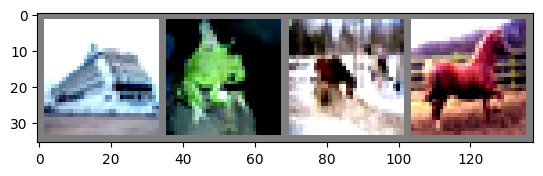

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [6]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        # <your code here>

        self.conv_1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv_2=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv_3=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.batch_norm_1=nn.BatchNorm2d(num_features=32)
        self.batch_norm_2=nn.BatchNorm2d(num_features=32)
        self.relu=nn.ReLU()
        self.avg_pooling=nn.AvgPool2d(8)
        self.flatten=nn.Flatten()
        self.fc=nn.Linear(32*4*4, n_classes)


        

    def forward(self, x):

        # <your code here>

        out1=self.conv_1(x)
        out1=self.batch_norm_1(out1)
        out1=self.relu(out1)
        out1=self.conv_2(out1)
        out1=self.batch_norm_2(out1)

        out2=self.conv_3(x)

        out=out1+out2
        out=self.relu(out)
        out=self.avg_pooling(out)
        out=self.flatten(out)
        out=self.fc(out)
        
        return out

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (avg_pooling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [31]:
def test(model, criterion, loader):
    loss_log = []
    acc_log = []
    model.eval()
    with torch.no_grad():

        for data, target in tqdm(loader):

            # <your code here>

            data, target = data.to(device), target.to(device)
            y_pred=net(data)
            loss=criterion(y_pred, target)
            #loss_log=torch.cat( (loss_log, loss.cpu().unsqueeze(0) / target.cpu().size(0)) )
            loss_log.append(loss.cpu().data / target.cpu().size(0))
            pred_class=torch.argmax(y_pred.cpu(), dim=-1)
            #acc_log=torch.cat( (acc_log, (pred_class==target.cpu()).sum().unsqueeze(0)))
            acc_log.append( (pred_class==target.cpu()).sum() / target.cpu().size(0) )

        return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, criterion, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader):

        # <your code here>
        data, target = data.to(device), target.to(device)
        y_pred=net(data)
        loss=criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #loss_log=torch.cat( (loss_log, loss.cpu().unsqueeze(0) / target.cpu().size(0)) )
        loss_log.append(loss.cpu().data / target.cpu().size(0))
        pred_class=torch.argmax(y_pred.cpu(), dim=-1)
        #acc_log=torch.cat( (acc_log, (pred_class==target.cpu()).sum().unsqueeze(0)))
        acc_log.append( (pred_class==target.cpu()).sum() / target.cpu().size(0) )

    return loss_log, acc_log


def train(model, criterion, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, criterion, optimizer, train_loader)
        val_loss, val_acc = test(model, criterion, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [32]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion=nn.CrossEntropyLoss()
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader
)

100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 0
 train loss: 0.018852638080716133, train acc: 0.5742157101631165
 val loss: 0.01834169775247574, val acc: 0.5921542644500732



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 1
 train loss: 0.01658918522298336, train acc: 0.63127201795578
 val loss: 0.016794374212622643, val acc: 0.6267509460449219



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 2
 train loss: 0.015497563406825066, train acc: 0.6551563739776611
 val loss: 0.015952477231621742, val acc: 0.6494902968406677



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 3
 train loss: 0.014833610504865646, train acc: 0.6698836088180542
 val loss: 0.015168017707765102, val acc: 0.6642951965332031



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 4
 train loss: 0.014469524845480919, train acc: 0.675788402557373
 val loss: 0.014753849245607853, val acc: 0.6767730116844177



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 5
 train loss: 0.013970106840133667, train acc: 0.6902299523353577
 val loss: 0.01622650772333145, val acc: 0.651928186416626



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 6
 train loss: 0.013589678332209587, train acc: 0.6975262761116028
 val loss: 0.014606194570660591, val acc: 0.6817818880081177



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 7
 train loss: 0.013355704955756664, train acc: 0.702345609664917
 val loss: 0.015209836885333061, val acc: 0.6722739338874817



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 8
 train loss: 0.013135179877281189, train acc: 0.708360493183136
 val loss: 0.014579269103705883, val acc: 0.6810062527656555



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 9
 train loss: 0.01283173356205225, train acc: 0.715681254863739
 val loss: 0.01425131969153881, val acc: 0.6937057375907898



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 10
 train loss: 0.012705325148999691, train acc: 0.718056321144104
 val loss: 0.014128481037914753, val acc: 0.6890957355499268



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 11
 train loss: 0.012511287815868855, train acc: 0.7225858569145203
 val loss: 0.014287406578660011, val acc: 0.691356360912323



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 12
 train loss: 0.012353788129985332, train acc: 0.7247567772865295
 val loss: 0.01417055819183588, val acc: 0.693439781665802



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 13
 train loss: 0.012221720069646835, train acc: 0.7270827889442444
 val loss: 0.013729958795011044, val acc: 0.7042553424835205



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 14
 train loss: 0.0120571069419384, train acc: 0.7331507802009583
 val loss: 0.01344585232436657, val acc: 0.7061834931373596



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 15
 train loss: 0.011915532872080803, train acc: 0.7366601824760437
 val loss: 0.013379575684666634, val acc: 0.7126551866531372



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 16
 train loss: 0.01174843218177557, train acc: 0.7395861148834229
 val loss: 0.013730289414525032, val acc: 0.7063387036323547



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 17
 train loss: 0.011715608648955822, train acc: 0.7410796284675598
 val loss: 0.014684184454381466, val acc: 0.6885638236999512



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 18
 train loss: 0.01152455061674118, train acc: 0.7449317574501038
 val loss: 0.013529002666473389, val acc: 0.7024378776550293



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]

Epoch 19
 train loss: 0.011471210047602654, train acc: 0.7468292713165283
 val loss: 0.013466866686940193, val acc: 0.7137632966041565



Посчитайте точность на тестовой выборке:

In [34]:
# <your code here>
test_loss, test_acc = test(net, criterion, test_loader)
test_acc

100%|██████████| 157/157 [00:34<00:00,  4.56it/s]


0.70919585

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

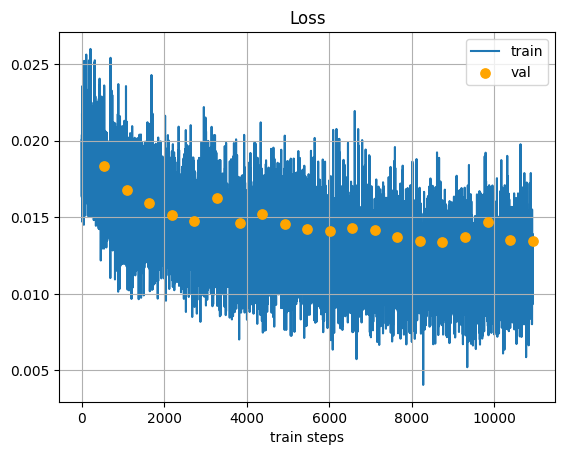

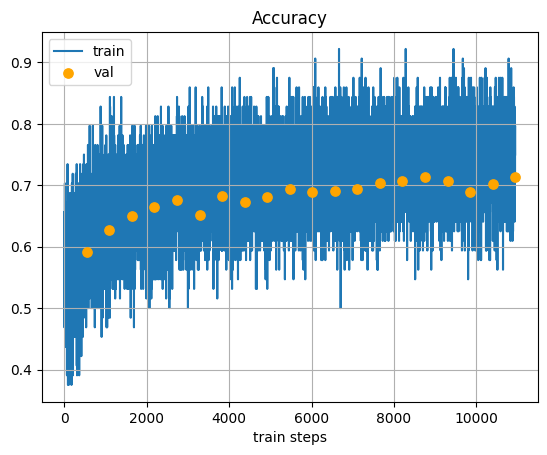

In [41]:
# <your code here>

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker=".", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

plot_history(train_loss_log, val_loss_log, 'Loss')
plot_history(train_acc_log, val_acc_log, 'Accuracy')

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [43]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, scheduler
)

100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 0
 train loss: 0.02326289191842079, train acc: 0.47225120663642883
 val loss: 0.020397795364260674, val acc: 0.5411347150802612



100%|██████████| 235/235 [00:42<00:00,  5.59it/s]


Epoch 1
 train loss: 0.018488692119717598, train acc: 0.5845398306846619
 val loss: 0.017871828749775887, val acc: 0.6013962626457214



100%|██████████| 235/235 [00:42<00:00,  5.51it/s]


Epoch 2
 train loss: 0.016511330381035805, train acc: 0.6334225535392761
 val loss: 0.015782831236720085, val acc: 0.6522606611251831



100%|██████████| 235/235 [00:41<00:00,  5.61it/s]


Epoch 3
 train loss: 0.01554150227457285, train acc: 0.6534302234649658
 val loss: 0.016491374000906944, val acc: 0.6366134285926819



100%|██████████| 235/235 [00:41<00:00,  5.62it/s]


Epoch 4
 train loss: 0.015107802115380764, train acc: 0.6612570285797119
 val loss: 0.01522394921630621, val acc: 0.6652260422706604



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 5
 train loss: 0.01456573884934187, train acc: 0.6747110486030579
 val loss: 0.015101129189133644, val acc: 0.6669325828552246



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 6
 train loss: 0.014213831163942814, train acc: 0.6843252182006836
 val loss: 0.015286325477063656, val acc: 0.6679078340530396



100%|██████████| 235/235 [00:40<00:00,  5.74it/s]


Epoch 7
 train loss: 0.013859688304364681, train acc: 0.6911358833312988
 val loss: 0.014602139592170715, val acc: 0.6824246048927307



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 8
 train loss: 0.01368173211812973, train acc: 0.6957307457923889
 val loss: 0.014679324813187122, val acc: 0.6772163510322571



100%|██████████| 235/235 [00:41<00:00,  5.61it/s]


Epoch 9
 train loss: 0.013343445025384426, train acc: 0.7021823525428772
 val loss: 0.01437761913985014, val acc: 0.6835549473762512



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 10
 train loss: 0.011746101081371307, train acc: 0.7387250065803528
 val loss: 0.01310774590820074, val acc: 0.7147606611251831



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 11
 train loss: 0.011468918062746525, train acc: 0.7478739023208618
 val loss: 0.013086594641208649, val acc: 0.716777503490448



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 12
 train loss: 0.011387673206627369, train acc: 0.7475597262382507
 val loss: 0.013022743165493011, val acc: 0.7182623744010925



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 13
 train loss: 0.011297631077468395, train acc: 0.749640941619873
 val loss: 0.013015391305088997, val acc: 0.7179743051528931



100%|██████████| 235/235 [00:41<00:00,  5.61it/s]


Epoch 14
 train loss: 0.011252302676439285, train acc: 0.7508854866027832
 val loss: 0.013024450279772282, val acc: 0.7192819118499756



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 15
 train loss: 0.010999467223882675, train acc: 0.7587938904762268
 val loss: 0.012858414091169834, val acc: 0.7232047915458679



100%|██████████| 235/235 [00:42<00:00,  5.48it/s]


Epoch 16
 train loss: 0.010964324697852135, train acc: 0.7583491206169128
 val loss: 0.012863688170909882, val acc: 0.7224956154823303



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 17
 train loss: 0.010962779633700848, train acc: 0.7587082386016846
 val loss: 0.012845746241509914, val acc: 0.722894549369812



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 18
 train loss: 0.010948852635920048, train acc: 0.7587653398513794
 val loss: 0.01284103374928236, val acc: 0.7226285934448242



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]

Epoch 19
 train loss: 0.010958731174468994, train acc: 0.7590183615684509
 val loss: 0.012854209169745445, val acc: 0.7238031625747681



Посчитайте точность на тестовой выборке:

In [44]:
# <your code here>
test_loss2, test_acc2 = test(net, criterion, test_loader)
test_acc2

100%|██████████| 157/157 [00:34<00:00,  4.52it/s]


0.71496814

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [49]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader
)

100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 0
 train loss: 0.027819683775305748, train acc: 0.3720618784427643
 val loss: 0.02490300126373768, val acc: 0.44434839487075806



100%|██████████| 235/235 [00:42<00:00,  5.55it/s]


Epoch 1
 train loss: 0.02348085306584835, train acc: 0.4692233204841614
 val loss: 0.022448526695370674, val acc: 0.5005097985267639



100%|██████████| 235/235 [00:42<00:00,  5.52it/s]


Epoch 2
 train loss: 0.021706731989979744, train acc: 0.5113239884376526
 val loss: 0.021391451358795166, val acc: 0.5221852660179138



100%|██████████| 235/235 [00:40<00:00,  5.74it/s]


Epoch 3
 train loss: 0.020631620660424232, train acc: 0.5379382371902466
 val loss: 0.019999941810965538, val acc: 0.554033637046814



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 4
 train loss: 0.019790921360254288, train acc: 0.5546650886535645
 val loss: 0.019254054874181747, val acc: 0.5751994848251343



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 5
 train loss: 0.019046539440751076, train acc: 0.574558436870575
 val loss: 0.019111718982458115, val acc: 0.5673980116844177



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 6
 train loss: 0.01838693581521511, train acc: 0.5880778431892395
 val loss: 0.01809464581310749, val acc: 0.5981605052947998



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 7
 train loss: 0.017793802544474602, train acc: 0.6030376553535461
 val loss: 0.017595509067177773, val acc: 0.6142064929008484



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 8
 train loss: 0.0172959603369236, train acc: 0.6164999604225159
 val loss: 0.017373578622937202, val acc: 0.6142951846122742



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 9
 train loss: 0.0167757049202919, train acc: 0.6257222890853882
 val loss: 0.016834164038300514, val acc: 0.6238918900489807



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 10
 train loss: 0.016361624002456665, train acc: 0.6341570615768433
 val loss: 0.016595305874943733, val acc: 0.6328679323196411



100%|██████████| 235/235 [00:41<00:00,  5.73it/s]


Epoch 11
 train loss: 0.016064943745732307, train acc: 0.6414125561714172
 val loss: 0.01616806536912918, val acc: 0.6417331099510193



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 12
 train loss: 0.01575274020433426, train acc: 0.6493658423423767
 val loss: 0.0160952340811491, val acc: 0.6447251439094543



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 13
 train loss: 0.015481401234865189, train acc: 0.6539974212646484
 val loss: 0.01564657688140869, val acc: 0.6543217897415161



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 14
 train loss: 0.015216086059808731, train acc: 0.6633095741271973
 val loss: 0.015720225870609283, val acc: 0.6523714065551758



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 15
 train loss: 0.015038732439279556, train acc: 0.6653662919998169
 val loss: 0.015799956396222115, val acc: 0.6462988257408142



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 16
 train loss: 0.01491411030292511, train acc: 0.6691327691078186
 val loss: 0.015253639779984951, val acc: 0.6633200645446777



100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 17
 train loss: 0.014699665829539299, train acc: 0.6748865842819214
 val loss: 0.015256072394549847, val acc: 0.6631206274032593



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 18
 train loss: 0.014558199793100357, train acc: 0.6788039803504944
 val loss: 0.014902155846357346, val acc: 0.6716090440750122



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]

Epoch 19
 train loss: 0.014505884610116482, train acc: 0.6768085956573486
 val loss: 0.014881439507007599, val acc: 0.6738919019699097



In [ ]:
#качество снизилось : 0,67 против 0,715 при поэтапном снижении learning rate
test_loss3, test_acc3 = test(net, criterion, test_loader)
test_acc3

100%|██████████| 157/157 [00:34<00:00,  4.58it/s]


0.67028266

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1) # lr циклически изменяется между двумя границами с постоянной частотой
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss4, test_acc4 = test(net, criterion, test_loader)
test_acc4


100%|██████████| 235/235 [00:40<00:00,  5.74it/s]


Epoch 0
 train loss: 0.023309824988245964, train acc: 0.4642857313156128
 val loss: 0.02031789720058441, val acc: 0.5419326424598694



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 1
 train loss: 0.01923222467303276, train acc: 0.5615655183792114
 val loss: 0.018661189824342728, val acc: 0.582269549369812



100%|██████████| 235/235 [00:41<00:00,  5.60it/s]


Epoch 2
 train loss: 0.017334237694740295, train acc: 0.6090362668037415
 val loss: 0.016976891085505486, val acc: 0.6235372424125671



100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 3
 train loss: 0.01613737642765045, train acc: 0.6339163184165955
 val loss: 0.016314731910824776, val acc: 0.6348404288291931



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 4
 train loss: 0.015348022803664207, train acc: 0.6567396521568298
 val loss: 0.01633472926914692, val acc: 0.6357269883155823



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 5
 train loss: 0.01472932007163763, train acc: 0.6733032464981079
 val loss: 0.014887990429997444, val acc: 0.6666223406791687



100%|██████████| 235/235 [00:42<00:00,  5.55it/s]


Epoch 6
 train loss: 0.014430856332182884, train acc: 0.678514301776886
 val loss: 0.015209030359983444, val acc: 0.6578014492988586



100%|██████████| 235/235 [00:40<00:00,  5.74it/s]


Epoch 7
 train loss: 0.01406087540090084, train acc: 0.6859044432640076
 val loss: 0.015222551301121712, val acc: 0.6746453642845154



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 8
 train loss: 0.013698475435376167, train acc: 0.6962775588035583
 val loss: 0.0140917943790555, val acc: 0.693439781665802



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 9
 train loss: 0.013424303382635117, train acc: 0.7022803425788879
 val loss: 0.014261477626860142, val acc: 0.6806073188781738



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 10
 train loss: 0.013177689164876938, train acc: 0.7102417349815369
 val loss: 0.01372960302978754, val acc: 0.6998448371887207



100%|██████████| 235/235 [00:41<00:00,  5.60it/s]


Epoch 11
 train loss: 0.01298257615417242, train acc: 0.7115435004234314
 val loss: 0.013890201225876808, val acc: 0.6939272880554199



100%|██████████| 235/235 [00:42<00:00,  5.58it/s]


Epoch 12
 train loss: 0.012796180322766304, train acc: 0.7168116569519043
 val loss: 0.013772580772638321, val acc: 0.6975398659706116



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 13
 train loss: 0.0126383937895298, train acc: 0.7207128405570984
 val loss: 0.01343780942261219, val acc: 0.7057402729988098



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 14
 train loss: 0.012383535504341125, train acc: 0.7239977717399597
 val loss: 0.013005957938730717, val acc: 0.7151373624801636



100%|██████████| 235/235 [00:41<00:00,  5.60it/s]


Epoch 15
 train loss: 0.01225912757217884, train acc: 0.728274405002594
 val loss: 0.013441566377878189, val acc: 0.7039893865585327



100%|██████████| 235/235 [00:42<00:00,  5.58it/s]


Epoch 16
 train loss: 0.012094583362340927, train acc: 0.7308411002159119
 val loss: 0.01325302105396986, val acc: 0.7100399136543274



100%|██████████| 235/235 [00:40<00:00,  5.77it/s]


Epoch 17
 train loss: 0.011953908018767834, train acc: 0.7366193532943726
 val loss: 0.012917845509946346, val acc: 0.7194814085960388



100%|██████████| 235/235 [00:40<00:00,  5.78it/s]


Epoch 18
 train loss: 0.01186802051961422, train acc: 0.7360929846763611
 val loss: 0.013105828315019608, val acc: 0.7132313847541809



100%|██████████| 235/235 [00:40<00:00,  5.79it/s]


Epoch 19
 train loss: 0.011663350276648998, train acc: 0.7424914836883545
 val loss: 0.012927885167300701, val acc: 0.7200354933738708



100%|██████████| 157/157 [00:33<00:00,  4.62it/s]


0.71287817

Your answers here:

CyclicLR с диапазоном 0.1-0.01 показал качество, сопоставимое с MultiStepLR (milestones=[10, 15], gamma=0.1): 0,713 против 0,715.
Худшее качество у оптимизатора с низким константным Learning rate.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5504175].


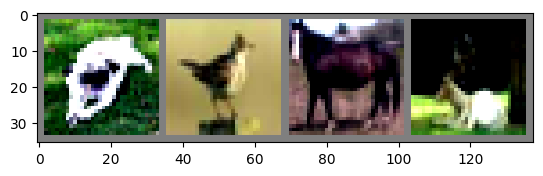

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5504175].


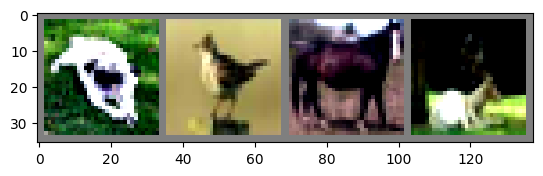

In [51]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [52]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, scheduler
)

100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


Epoch 0
 train loss: 0.02344394102692604, train acc: 0.4656282663345337
 val loss: 0.019603952765464783, val acc: 0.5519724488258362



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 1
 train loss: 0.018279582262039185, train acc: 0.5893183946609497
 val loss: 0.01711393892765045, val acc: 0.623847484588623



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 2
 train loss: 0.01656031794846058, train acc: 0.6321657299995422
 val loss: 0.01630469784140587, val acc: 0.6445478796958923



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 3
 train loss: 0.015674423426389694, train acc: 0.6541361808776855
 val loss: 0.016690129414200783, val acc: 0.6433953642845154



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 4
 train loss: 0.015008880756795406, train acc: 0.6673454642295837
 val loss: 0.015484455041587353, val acc: 0.6604831218719482



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 5
 train loss: 0.014611664228141308, train acc: 0.675637423992157
 val loss: 0.015167158097028732, val acc: 0.6643617153167725



100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Epoch 6
 train loss: 0.01431508082896471, train acc: 0.6858228445053101
 val loss: 0.015152908861637115, val acc: 0.6681737899780273



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 7
 train loss: 0.014087986201047897, train acc: 0.6882222890853882
 val loss: 0.014334394596517086, val acc: 0.6909352540969849



100%|██████████| 235/235 [00:41<00:00,  5.70it/s]


Epoch 8
 train loss: 0.01391487754881382, train acc: 0.6930946707725525
 val loss: 0.01461797021329403, val acc: 0.6809175610542297



100%|██████████| 235/235 [00:41<00:00,  5.64it/s]


Epoch 9
 train loss: 0.013574513606727123, train acc: 0.6975671052932739
 val loss: 0.013960829935967922, val acc: 0.698980450630188



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 10
 train loss: 0.012119520455598831, train acc: 0.7318245768547058
 val loss: 0.012859792448580265, val acc: 0.7230495810508728



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 11
 train loss: 0.01187546830624342, train acc: 0.7367458939552307
 val loss: 0.01276619266718626, val acc: 0.7235372066497803



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 12
 train loss: 0.011806224472820759, train acc: 0.7411938905715942
 val loss: 0.012639204040169716, val acc: 0.7261081337928772



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 13
 train loss: 0.01171916164457798, train acc: 0.743103563785553
 val loss: 0.01249647419899702, val acc: 0.728900671005249



100%|██████████| 235/235 [00:41<00:00,  5.67it/s]


Epoch 14
 train loss: 0.011661355383694172, train acc: 0.7436871528625488
 val loss: 0.012528099119663239, val acc: 0.7249557375907898



100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 15
 train loss: 0.01146200392395258, train acc: 0.7476821541786194
 val loss: 0.01244475319981575, val acc: 0.7321143746376038



100%|██████████| 235/235 [00:41<00:00,  5.64it/s]


Epoch 16
 train loss: 0.011444639414548874, train acc: 0.7474372982978821
 val loss: 0.01246524229645729, val acc: 0.7304078340530396



100%|██████████| 235/235 [00:41<00:00,  5.62it/s]


Epoch 17
 train loss: 0.011435778811573982, train acc: 0.7483962774276733
 val loss: 0.01250182930380106, val acc: 0.7270833849906921



100%|██████████| 235/235 [00:43<00:00,  5.35it/s]


Epoch 18
 train loss: 0.011412663385272026, train acc: 0.7478780746459961
 val loss: 0.012405214831233025, val acc: 0.732025682926178



100%|██████████| 235/235 [00:43<00:00,  5.39it/s]

Epoch 19
 train loss: 0.01140599511563778, train acc: 0.7493225932121277
 val loss: 0.012452206574380398, val acc: 0.7287676930427551



Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
#добавление 1 аугментации повысило качество модели на 1% 
test_loss5, test_acc5 = test(net, criterion, test_loader)
test_acc5

100%|██████████| 157/157 [00:35<00:00,  4.46it/s]


0.7223328

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [55]:
# <your code here>
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 45)), #поворот изображение на Х градусов, Х - от 0 до 45
        transforms.RandomPosterize(bits=2), #уменьшает количество бит для каждого цветового канала
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss6, test_acc6 = test(net, criterion, test_loader)
test_acc6

100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 0
 train loss: 0.025265883654356003, train acc: 0.4198346436023712
 val loss: 0.021662143990397453, val acc: 0.5043882727622986



100%|██████████| 235/235 [00:41<00:00,  5.63it/s]


Epoch 1
 train loss: 0.021684588864445686, train acc: 0.502983033657074
 val loss: 0.020725281909108162, val acc: 0.5304521322250366



100%|██████████| 235/235 [00:41<00:00,  5.61it/s]


Epoch 2
 train loss: 0.020327001810073853, train acc: 0.5379056334495544
 val loss: 0.019862856715917587, val acc: 0.5534352660179138



100%|██████████| 235/235 [00:43<00:00,  5.39it/s]


Epoch 3
 train loss: 0.019574390724301338, train acc: 0.5549874305725098
 val loss: 0.01935371197760105, val acc: 0.5664228796958923



100%|██████████| 235/235 [00:43<00:00,  5.45it/s]


Epoch 4
 train loss: 0.018932601436972618, train acc: 0.5743054747581482
 val loss: 0.019161120057106018, val acc: 0.5712543725967407



100%|██████████| 235/235 [00:43<00:00,  5.41it/s]


Epoch 5
 train loss: 0.018551263958215714, train acc: 0.5817446112632751
 val loss: 0.018560729920864105, val acc: 0.5855275392532349



100%|██████████| 235/235 [00:41<00:00,  5.61it/s]


Epoch 6
 train loss: 0.018241899088025093, train acc: 0.5886980891227722
 val loss: 0.01772242598235607, val acc: 0.5985814929008484



100%|██████████| 235/235 [00:41<00:00,  5.64it/s]


Epoch 7
 train loss: 0.018082981929183006, train acc: 0.5901631116867065
 val loss: 0.01837814413011074, val acc: 0.592597484588623



100%|██████████| 235/235 [00:42<00:00,  5.48it/s]


Epoch 8
 train loss: 0.01794966123998165, train acc: 0.5943294167518616
 val loss: 0.017896294593811035, val acc: 0.5971631407737732



100%|██████████| 235/235 [00:41<00:00,  5.65it/s]


Epoch 9
 train loss: 0.017584320157766342, train acc: 0.6030907034873962
 val loss: 0.01770632714033127, val acc: 0.605518639087677



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 10
 train loss: 0.01628844439983368, train acc: 0.6345121264457703
 val loss: 0.016349777579307556, val acc: 0.633643627166748



100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 11
 train loss: 0.016044126823544502, train acc: 0.6372666358947754
 val loss: 0.016311977058649063, val acc: 0.6350398659706116



100%|██████████| 235/235 [00:42<00:00,  5.56it/s]


Epoch 12
 train loss: 0.01604905165731907, train acc: 0.6419267058372498
 val loss: 0.01635063998401165, val acc: 0.632446825504303



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 13
 train loss: 0.015982719138264656, train acc: 0.6412738561630249
 val loss: 0.01619977317750454, val acc: 0.6368350982666016



100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch 14
 train loss: 0.01593380607664585, train acc: 0.6444486379623413
 val loss: 0.0161584559828043, val acc: 0.640159547328949



  0%|          | 0/547 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022DE1887D80>
Traceback (most recent call last):
  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 235/235 [00:41<00:00,  5.65it/s]


Epoch 15
 train loss: 0.015753259882330894, train acc: 0.647521436214447
 val loss: 0.016011493280529976, val acc: 0.6396054625511169



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 16
 train loss: 0.015696369111537933, train acc: 0.6463175415992737
 val loss: 0.015934424474835396, val acc: 0.6443483829498291



100%|██████████| 235/235 [00:41<00:00,  5.68it/s]


Epoch 17
 train loss: 0.015624850057065487, train acc: 0.6470888257026672
 val loss: 0.01604016311466694, val acc: 0.6396941542625427



100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 18
 train loss: 0.015576674602925777, train acc: 0.6502309441566467
 val loss: 0.01589963585138321, val acc: 0.6438829898834229



100%|██████████| 235/235 [00:43<00:00,  5.44it/s]


Epoch 19
 train loss: 0.015671871602535248, train acc: 0.6479865908622742
 val loss: 0.01598796807229519, val acc: 0.6436170339584351



100%|██████████| 157/157 [00:35<00:00,  4.39it/s]


0.62619424

In [ ]:
# Если применить много сложных аугментаций, то качество модели при том же количестве эпох значительно снижается. 
# Возможно это связано с недообучением (лосс на валидации очень медленно, но снижается), а данные слишком разнообразны


transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)), #поворот изображение на Х градусов, Х - от 0 до 180
        transforms.ElasticTransform(alpha=250.0), #добавляет линиям на изображении "дрожание"
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)), #заблюривает, "размывает" изображение
        transforms.RandomPosterize(bits=2), #уменьшает количество бит для каждого цветового канала
        transforms.RandomEqualize(), #выравнивает гистограмму изображения
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss7, test_acc7 = test(net, criterion, test_loader)
test_acc7

100%|██████████| 235/235 [00:44<00:00,  5.25it/s]


Epoch 0
 train loss: 0.034092918038368225, train acc: 0.1948166936635971
 val loss: 0.03334653377532959, val acc: 0.21057181060314178



100%|██████████| 235/235 [00:43<00:00,  5.36it/s]


Epoch 1
 train loss: 0.033257607370615005, train acc: 0.2169504165649414
 val loss: 0.03326617553830147, val acc: 0.21988031268119812



100%|██████████| 235/235 [00:43<00:00,  5.41it/s]


Epoch 2
 train loss: 0.032774344086647034, train acc: 0.22935165464878082
 val loss: 0.032942481338977814, val acc: 0.2204122394323349



100%|██████████| 235/235 [00:43<00:00,  5.38it/s]


Epoch 3
 train loss: 0.03261932358145714, train acc: 0.22938838601112366
 val loss: 0.03258201852440834, val acc: 0.23499557375907898



100%|██████████| 235/235 [00:43<00:00,  5.44it/s]


Epoch 4
 train loss: 0.032429277896881104, train acc: 0.23556247353553772
 val loss: 0.03267691656947136, val acc: 0.2326240986585617



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 5
 train loss: 0.032331936061382294, train acc: 0.23729269206523895
 val loss: 0.03248866647481918, val acc: 0.24618792533874512



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 6
 train loss: 0.032173171639442444, train acc: 0.24831059575080872
 val loss: 0.032366640865802765, val acc: 0.2577570974826813



100%|██████████| 235/235 [00:42<00:00,  5.47it/s]


Epoch 7
 train loss: 0.032083697617053986, train acc: 0.2434627115726471
 val loss: 0.03197842091321945, val acc: 0.2495567500591278



100%|██████████| 235/235 [00:42<00:00,  5.48it/s]


Epoch 8
 train loss: 0.03203877806663513, train acc: 0.25129765272140503
 val loss: 0.032036446034908295, val acc: 0.2500443160533905



100%|██████████| 235/235 [00:42<00:00,  5.51it/s]


Epoch 9
 train loss: 0.03193442150950432, train acc: 0.2502162754535675
 val loss: 0.03191622346639633, val acc: 0.2574911117553711



100%|██████████| 235/235 [00:42<00:00,  5.50it/s]


Epoch 10
 train loss: 0.031235620379447937, train acc: 0.2694690227508545
 val loss: 0.03141389042139053, val acc: 0.272628515958786



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 11
 train loss: 0.031144943088293076, train acc: 0.2719786465167999
 val loss: 0.03118983656167984, val acc: 0.2748670279979706



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 12
 train loss: 0.031056029722094536, train acc: 0.27534931898117065
 val loss: 0.03113049454987049, val acc: 0.27373671531677246



100%|██████████| 235/235 [00:43<00:00,  5.41it/s]


Epoch 13
 train loss: 0.03102889657020569, train acc: 0.278719961643219
 val loss: 0.031074458733201027, val acc: 0.2764849066734314



100%|██████████| 235/235 [00:43<00:00,  5.45it/s]


Epoch 14
 train loss: 0.031003840267658234, train acc: 0.2775079905986786
 val loss: 0.03115643560886383, val acc: 0.28207001090049744



100%|██████████| 235/235 [00:42<00:00,  5.50it/s]


Epoch 15
 train loss: 0.030902018770575523, train acc: 0.2820335030555725
 val loss: 0.03096846677362919, val acc: 0.2821808457374573



100%|██████████| 235/235 [00:43<00:00,  5.41it/s]


Epoch 16
 train loss: 0.03082999959588051, train acc: 0.2813561260700226
 val loss: 0.030919885262846947, val acc: 0.2835550010204315



100%|██████████| 235/235 [00:42<00:00,  5.53it/s]


Epoch 17
 train loss: 0.030861731618642807, train acc: 0.28088271617889404
 val loss: 0.030776163563132286, val acc: 0.28512853384017944



100%|██████████| 235/235 [00:42<00:00,  5.53it/s]


Epoch 18
 train loss: 0.03083225153386593, train acc: 0.28575101494789124
 val loss: 0.03106190823018551, val acc: 0.27584221959114075



100%|██████████| 235/235 [00:43<00:00,  5.42it/s]


Epoch 19
 train loss: 0.03083968721330166, train acc: 0.28526541590690613
 val loss: 0.030890164896845818, val acc: 0.28953903913497925



100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


0.33459395

Your answers here:

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

wandb: Currently logged in as: pooh_08 (pooh_08-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 235/235 [00:43<00:00,  5.40it/s]


Epoch 0
 train loss: 0.026201069355010986, train acc: 0.3946036696434021
 val loss: 0.02445371076464653, val acc: 0.4474290609359741



100%|██████████| 235/235 [00:44<00:00,  5.23it/s]


Epoch 1
 train loss: 0.022415965795516968, train acc: 0.48619088530540466
 val loss: 0.022061392664909363, val acc: 0.5039007067680359



100%|██████████| 235/235 [00:42<00:00,  5.49it/s]


Epoch 2
 train loss: 0.020833725109696388, train acc: 0.5255410671234131
 val loss: 0.021090000867843628, val acc: 0.5199246406555176



100%|██████████| 235/235 [00:45<00:00,  5.17it/s]


Epoch 3
 train loss: 0.02011917345225811, train acc: 0.544528603553772
 val loss: 0.020106175914406776, val acc: 0.5501329898834229



100%|██████████| 235/235 [00:42<00:00,  5.55it/s]


Epoch 4
 train loss: 0.0195155031979084, train acc: 0.5554730296134949
 val loss: 0.019205430522561073, val acc: 0.5751107931137085



100%|██████████| 235/235 [00:41<00:00,  5.64it/s]


Epoch 5
 train loss: 0.019135121256113052, train acc: 0.5673274397850037
 val loss: 0.019712695851922035, val acc: 0.560882031917572



100%|██████████| 235/235 [00:41<00:00,  5.63it/s]


Epoch 6
 train loss: 0.018780093640089035, train acc: 0.5733587145805359
 val loss: 0.01904522255063057, val acc: 0.5710106492042542



100%|██████████| 235/235 [00:41<00:00,  5.63it/s]


Epoch 7
 train loss: 0.018557682633399963, train acc: 0.5816670656204224
 val loss: 0.018907472491264343, val acc: 0.5755541324615479



100%|██████████| 235/235 [00:41<00:00,  5.62it/s]


Epoch 8
 train loss: 0.018294012174010277, train acc: 0.5875514149665833
 val loss: 0.019468583166599274, val acc: 0.5687500238418579



100%|██████████| 235/235 [00:41<00:00,  5.62it/s]


Epoch 9
 train loss: 0.018068062141537666, train acc: 0.5932521224021912
 val loss: 0.018543511629104614, val acc: 0.5838873386383057



100%|██████████| 235/235 [00:43<00:00,  5.45it/s]


Epoch 10
 train loss: 0.017951728776097298, train acc: 0.5961371660232544
 val loss: 0.0181050356477499, val acc: 0.5934397578239441



100%|██████████| 235/235 [00:42<00:00,  5.53it/s]


Epoch 11
 train loss: 0.017838960513472557, train acc: 0.6004627346992493
 val loss: 0.018267923966050148, val acc: 0.5874335169792175



100%|██████████| 235/235 [00:46<00:00,  5.05it/s]


Epoch 12
 train loss: 0.017626872286200523, train acc: 0.6018338799476624
 val loss: 0.01721186377108097, val acc: 0.6133421659469604



100%|██████████| 235/235 [00:43<00:00,  5.39it/s]


Epoch 13
 train loss: 0.0174639280885458, train acc: 0.6077753901481628
 val loss: 0.017370160669088364, val acc: 0.6108599901199341



100%|██████████| 235/235 [00:43<00:00,  5.42it/s]


Epoch 14
 train loss: 0.01747874729335308, train acc: 0.6072611808776855
 val loss: 0.017574278637766838, val acc: 0.6112589240074158



100%|██████████| 235/235 [00:43<00:00,  5.39it/s]


Epoch 15
 train loss: 0.017277240753173828, train acc: 0.611558198928833
 val loss: 0.017202498391270638, val acc: 0.6179078221321106



100%|██████████| 235/235 [00:44<00:00,  5.31it/s]


Epoch 16
 train loss: 0.017227552831172943, train acc: 0.6102033853530884
 val loss: 0.017017701640725136, val acc: 0.6228501200675964



100%|██████████| 235/235 [00:42<00:00,  5.54it/s]


Epoch 17
 train loss: 0.01716771349310875, train acc: 0.6128068566322327
 val loss: 0.017208602279424667, val acc: 0.6126329898834229



100%|██████████| 235/235 [00:43<00:00,  5.36it/s]


Epoch 18
 train loss: 0.017025629058480263, train acc: 0.6164182424545288
 val loss: 0.017545171082019806, val acc: 0.6057623624801636



100%|██████████| 235/235 [00:44<00:00,  5.26it/s]

Epoch 19
 train loss: 0.016947777941823006, train acc: 0.6196257472038269
 val loss: 0.017084812745451927, val acc: 0.6156471967697144



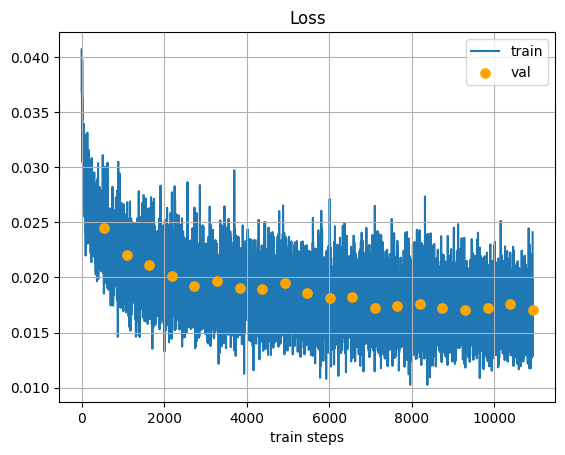

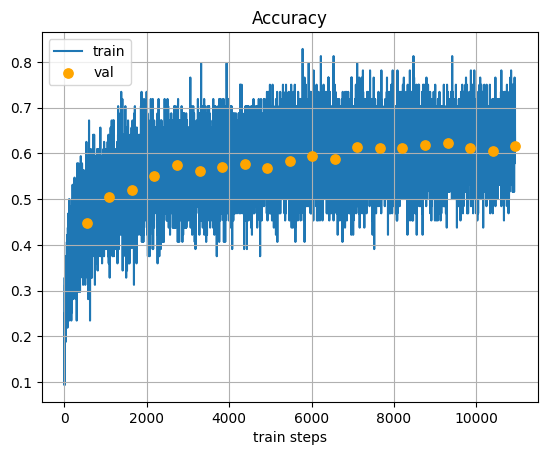

In [61]:
# <your code here>
# https://wandb.ai/pooh_08-hse/wandb_project?nw=nwuserpooh_08 

def test(model, criterion, loader):
    loss_log = []
    acc_log = []
    model.eval()
    with torch.no_grad():

        for data, target in tqdm(loader):

            # <your code here>

            data, target = data.to(device), target.to(device)
            y_pred=net(data)
            loss=criterion(y_pred, target)
            #loss_log=torch.cat( (loss_log, loss.cpu().unsqueeze(0) / target.cpu().size(0)) )
            loss_log.append(loss.cpu().data / target.cpu().size(0))
            pred_class=torch.argmax(y_pred.cpu(), dim=-1)
            #acc_log=torch.cat( (acc_log, (pred_class==target.cpu()).sum().unsqueeze(0)))
            acc_log.append( (pred_class==target.cpu()).sum() / target.cpu().size(0) )

        return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, criterion, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader):

        # <your code here>
        data, target = data.to(device), target.to(device)
        y_pred=net(data)
        loss=criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #loss_log=torch.cat( (loss_log, loss.cpu().unsqueeze(0) / target.cpu().size(0)) )
        loss_log.append(loss.cpu().data / target.cpu().size(0))
        pred_class=torch.argmax(y_pred.cpu(), dim=-1)
        #acc_log=torch.cat( (acc_log, (pred_class==target.cpu()).sum().unsqueeze(0)))
        acc_log.append( (pred_class==target.cpu()).sum() / target.cpu().size(0) )

    return loss_log, acc_log


def train(model, criterion, optimizer, n_epochs, train_loader, val_loader, scheduler=None, wandb_project=None):

    # подключаем wandb
    if wandb_project:
        import wandb

        wandb.init(project='wandb_project')
        wandb.watch(model)

    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, criterion, optimizer, train_loader)
        val_loss, val_acc = test(model, criterion, val_loader)

        if wandb_project:
                wandb.log(
                    {
                        "mean val loss": np.mean(val_loss),
                        "mean val accuracy": np.mean(val_acc),
                    }
                )

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    plot_history(train_loss_log, val_loss_log, 'Loss')
    plot_history(train_acc_log, val_acc_log, 'Accuracy')

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
criterion=nn.CrossEntropyLoss()
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, criterion, optimizer, 20, train_loader, val_loader, wandb_project=True
)

In [59]:
%pip install wandb

  Using cached wandb-0.19.10-py3-none-win_amd64.whl.metadata (10 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached sentry_sdk-2.27.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached setproctitle-1.3.6-cp311-cp311-win_amd64.whl.metadata (10 kB)
Using cached wandb-0.19.10-py3-none-win_amd64.whl (20.7 MB)
Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
Using cached sentry_sdk-2.27.0-py2.py3-none-any.whl (340 kB)
Using cached setproctitle-1.3.6-cp311-cp311-win_amd64.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


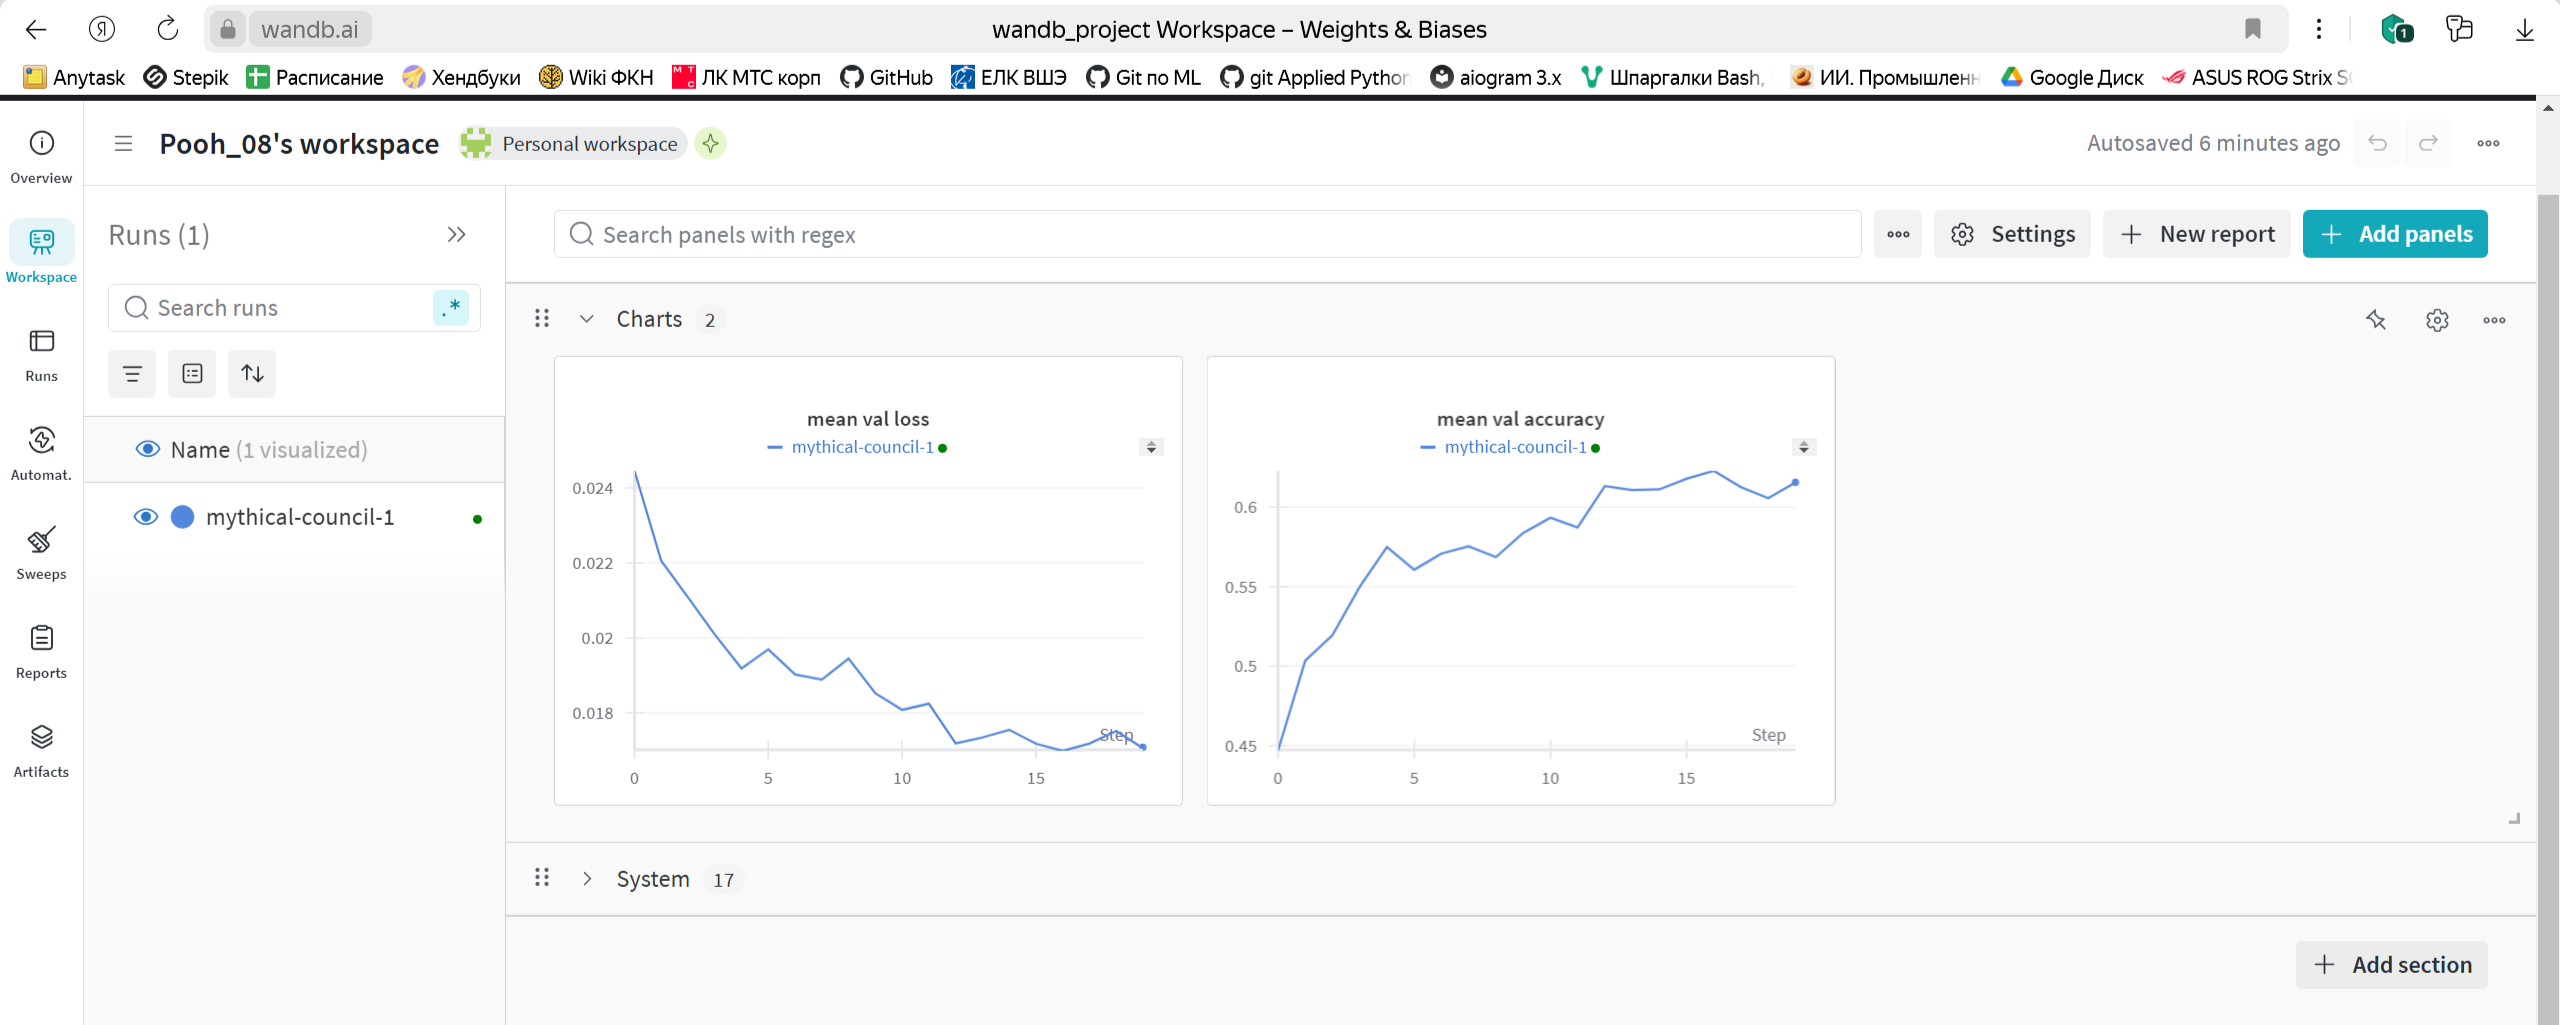

Workspace link: https://wandb.ai/pooh_08-hse/wandb_project?nw=nwuserpooh_08 

Report link: https://wandb.ai/pooh_08-hse/wandb_project/reports/Untitled-Report--VmlldzoxMjYyNDY1NA 